# Unamortised VAE implementation

We seek an API that trains an LVM given
1. Model
2. Loss function
3. Train step

In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [2]:
import jax
import hlax
import jax.numpy as jnp
import flax.linen as nn

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=True, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(20)(z)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    latent_dim: int
    n_hidden: int = 100
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.elu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.elu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z

## Initialisiation

In [5]:
batch_size = 200
key = jax.random.PRNGKey(314)
warmup, test = hlax.datasets.load_fashion_mnist(n_train=1000, n_test=100)
X_warmup = warmup[0]

lossfn_vae = hlax.losses.iwae_bern
lossfn_hardem = hlax.losses.hard_nmll_bern

dim_latent = 100
num_obs, *dim_obs = X_warmup.shape

model_vae = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], Encoder, Decoder)


key, key_params_init, key_eps_init = jax.random.split(key, 3)
# Initialise model consider total number of observations.
# We will then slice over the batches
batch_init = jnp.ones((num_obs, *dim_obs))
params = model_vae.init(key_params_init, batch_init, key_eps_init, num_samples=4)

jax.tree_map(jnp.shape, params)

FrozenDict({
    params: {
        decoder: {
            Dense_0: {
                bias: (20,),
                kernel: (100, 20),
            },
            mean: {
                bias: (784,),
                kernel: (20, 784),
            },
        },
        encoder: {
            Dense_0: {
                bias: (1000, 100),
                kernel: (1000, 784, 100),
            },
            Dense_1: {
                bias: (1000, 100),
                kernel: (1000, 100, 100),
            },
            Dense_2: {
                bias: (1000, 100),
                kernel: (1000, 100, 100),
            },
            Dense_3: {
                bias: (1000, 100),
                kernel: (1000, 100, 100),
            },
        },
    },
})

In [6]:
key_batch, keys_vae = jax.random.split(key)
batch_ixs = hlax.training.get_batch_train_ixs(key_batch, num_obs, batch_size)
num_batches = len(batch_ixs)
keys_vae = jax.random.split(keys_vae, num_batches)

## Param surgery

In [7]:
import optax
from functools import partial
from flax.core import freeze, unfreeze
from flax.training.train_state import TrainState

In [19]:
import distrax
def iwae_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder
    """
    batch_size = len(X_batch)

    # keys = jax.random.split(key, batch_size)
    # encode_decode = jax.vmap(apply_fn, (None, 0, 0))
    # encode_decode = encode_decode(params, X_batch, keys)
    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x - log_prob_z_post

    # negative Importance-weighted marginal log-likelihood
    niwmll = -jax.nn.logsumexp(log_prob, axis=-1, b=1/num_is_samples).mean()
    return niwmll

In [20]:
@jax.jit
def get_batch_adam_params_encoder(opt_state, ixs):
    """
    Get mu and nu optimiser parameters
    """
    encoder_sub_mu = opt_state[0].mu["params"]["encoder"]
    encoder_sub_nu = opt_state[0].nu["params"]["encoder"]
    
    encoder_sub_mu = jax.tree_map(lambda x: x[ixs], encoder_sub_mu)
    encoder_sub_nu = jax.tree_map(lambda x: x[ixs], encoder_sub_nu)
    
    return encoder_sub_mu, encoder_sub_nu


@jax.jit
def create_batch_adam_params(opt_state, ixs):
    mu_sub, nu_sub = get_batch_adam_params_encoder(opt_state, ixs)
    
    opt_state_batch = opt_state[0]
    mu_params = unfreeze(opt_state_batch.mu)
    nu_params = unfreeze(opt_state_batch.nu)
    
    # Replace encoder opt params with indexed params
    mu_params["params"]["encoder"] = mu_sub
    nu_params["params"]["encoder"] = nu_sub
    
    opt_state_batch = opt_state_batch._replace(
        mu=freeze(mu_params),
        nu=freeze(nu_params)
    )
    
    opt_state_batch = (
        opt_state_batch,
    ) + opt_state[1:]
    
    return opt_state_batch


@jax.jit
def update_pytree(pytree, pytree_subset, ixs):
    """
    Update the subset of a pytree.
    
    Parameters
    ----------
    pytree:
        Target pytree
    pytree_subset
        Values of the pytree to update
    ixs: DeviceArray
        Indices mapping from the subset to the
        full pytree
    """
    pytree_update = jax.tree_map(
        lambda vfull, vsub: vfull.at[ixs].set(vsub),
        pytree, pytree_subset
    )
    return pytree_update

In [21]:
num_samples = 10
tx = optax.adam(1e-3)

state = TrainState.create(
    apply_fn=partial(model_vae.apply, num_samples=num_samples),
    params=params,
    tx=tx,
)

In [22]:
batch_ix = batch_ixs[0]

In [23]:
@jax.jit
def create_batch_state(state, ixs):
    """
    Create a batch of the unamortised TrainStep
    """
    params_batch_encoder = jax.tree_map(lambda x: x[ixs], state.params["params"]["decoder"])
    params_batch = freeze({
        "params": {
            "encoder": params_batch_encoder,
            "decoder": state.params["params"]["decoder"]
        }
    })
    
    opt_state_batch = create_batch_adam_params(state.opt_state, ixs)
    
    state_batch = TrainState(
        step=state.step,
        apply_fn=state.apply_fn,
        tx=state.tx,
        params=params_batch,
        opt_state=opt_state_batch,
    )
    
    return state_batch

In [28]:
# 1. Obtain batch of encoder params
params_batch_encoder = jax.tree_map(lambda x: x[batch_ix], state.params["params"]["encoder"])


# 2. Construct encoder/decoder set of params
params_batch = freeze({
    "params": {
        "encoder": params_batch_encoder,
        "decoder": state.params["params"]["decoder"]
    }
})

# 3. Create batch of optimisation-state params
opt_state_batch = create_batch_adam_params(state.opt_state, batch_ix)


# 4. Create batch state
state_batch = TrainState(
    step=state.step,
    apply_fn=state.apply_fn,
    tx=state.tx,
    params=params_batch,
    opt_state=opt_state_batch,
)

# 5. Obtain updated batch state
X_batch = X_warmup[batch_ix]
loss_valgrad = jax.value_and_grad(iwae_bern, 1)
loss, grads_batch = loss_valgrad(key, state_batch.params, state_batch.apply_fn, X_batch)
new_state_batch = state_batch.apply_gradients(grads=grads_batch)


# 6. Update and reconstruct decoder params and batch of encoder params
params_encoder_update = unfreeze(state.params["params"]["encoder"])
params_batch_encoder_update = unfreeze(new_state_batch.params["params"]["encoder"])
params_encoder_update = update_pytree(params_encoder_update, params_batch_encoder_update, batch_ix)

params_decoder_update = unfreeze(new_state_batch.params["params"]["decoder"])

params_update = {
    "params": {
        "encoder": params_encoder_update,
        "decoder": params_decoder_update,
    }
}

params_update = freeze(params_update)


# 7. Update and reconstruct the optimiser state
mu_state = unfreeze(state.opt_state[0].mu)
nu_state = unfreeze(state.opt_state[0].nu)


# Update decoder optimisation-state params
mu_state["params"]["decoder"] = new_state_batch.opt_state[0].mu["params"]["decoder"]
nu_state["params"]["decoder"] = new_state_batch.opt_state[0].nu["params"]["decoder"]

# Update encoder optimisation-state params
batch_mu_encoder = unfreeze(new_state_batch.opt_state[0].mu["params"]["encoder"])
mu_state["params"]["encoder"] = update_pytree(mu_state["params"]["encoder"], batch_mu_encoder, batch_ix)

batch_nu_encoder = unfreeze(new_state_batch.opt_state[0].nu["params"]["encoder"])
nu_state["params"]["encoder"] = update_pytree(nu_state["params"]["encoder"], batch_nu_encoder, batch_ix)

mu_state = freeze(mu_state)
nu_state = freeze(nu_state)

opt_state_update = (
    state.opt_state[0]._replace(
        mu=mu_state,
        nu=nu_state,
    ),
) + state.opt_state[1:]


# 8. Obtain new state
state = TrainState(
    step=state_batch.step,
    apply_fn=state.apply_fn,
    tx=state.tx,
    params=params_update,
    opt_state=opt_state_update,
)

In [35]:
jax.tree_map(jnp.shape, params_batch)

FrozenDict({
    params: {
        decoder: {
            Dense_0: {
                bias: (20,),
                kernel: (20, 20),
            },
            mean: {
                bias: (784,),
                kernel: (20, 784),
            },
        },
        encoder: {
            Dense_0: {
                bias: (200, 100),
                kernel: (200, 784, 100),
            },
            Dense_1: {
                bias: (200, 100),
                kernel: (200, 100, 100),
            },
            Dense_2: {
                bias: (200, 20),
                kernel: (200, 100, 20),
            },
            Dense_3: {
                bias: (200, 20),
                kernel: (200, 100, 20),
            },
        },
    },
})

In [29]:
loss

DeviceArray(542.6132, dtype=float32)

## Testing API

In [42]:
from tqdm.notebook import tqdm

In [43]:
batch_size = 200
key = jax.random.PRNGKey(314)
key, key_params_init, key_eps_init = jax.random.split(key, 3)

warmup, test = hlax.datasets.load_fashion_mnist(n_train=1000, n_test=100, normalize=False)
X_warmup = warmup[0]

lossfn_vae = hlax.losses.iwae_bern
lossfn_hardem = hlax.losses.hard_nmll_bern

dim_latent = 20
num_obs, *dim_obs = X_warmup.shape
model_vae = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], Encoder, Decoder)

# Initialise model consider total number of observations.
# We will then slice over the batches
batch_init = jnp.ones((num_obs, *dim_obs))
params = model_vae.init(key_params_init, batch_init, key_eps_init, num_samples=4)

In [44]:
num_samples = 10
tx = optax.adam(1e-3)

state = TrainState.create(
    apply_fn=partial(model_vae.apply, num_samples=num_samples),
    params=params,
    tx=tx,
)

num_epochs = 100
keys = jax.random.split(key, num_epochs)

losses = []
for key_epoch in (pbar := tqdm(keys)):
    loss, state = hlax.unamortised.train_epoch(key_epoch, X_warmup, state, batch_size, iwae_bern)
    losses.append(loss)
    pbar.set_description(f"loss={loss:0.5e}")
losses = jnp.array(losses)

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

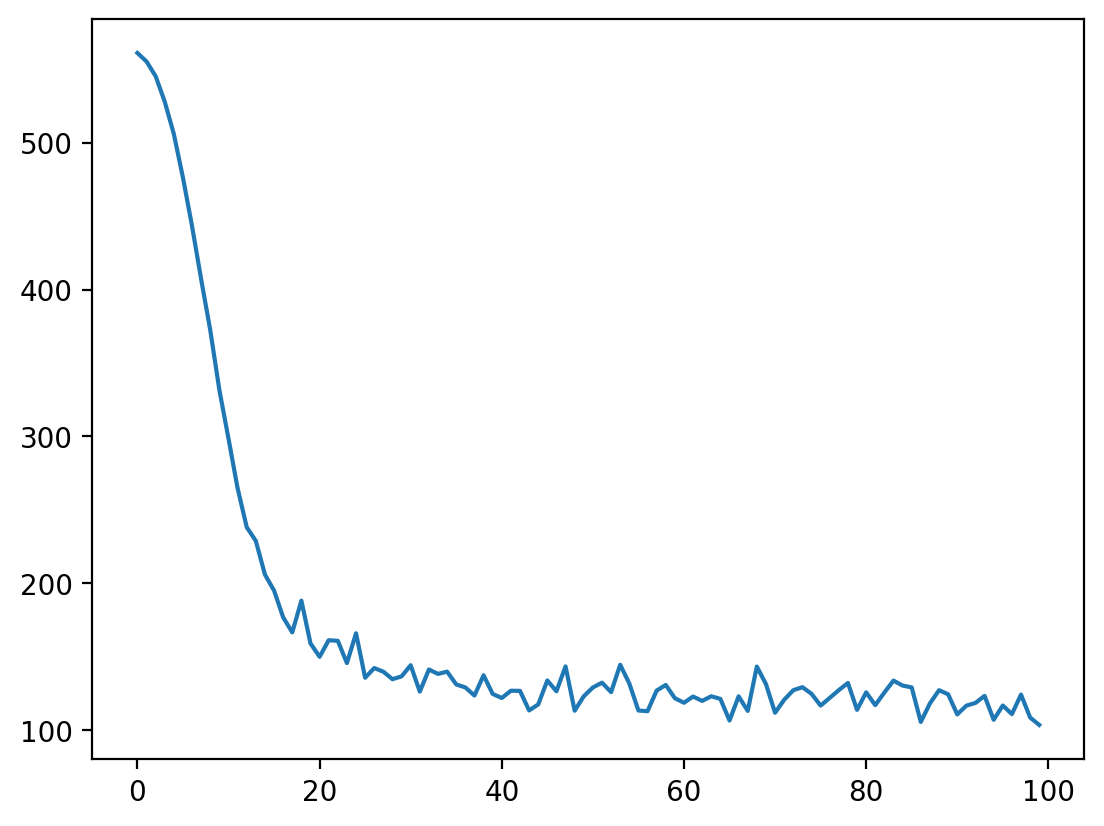

In [47]:
plt.plot(losses)